## boilerplate imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy import misc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import PIL

## Download data 

In [3]:
IMAGE_ROOT = "/home/jupyter/data/planes_satellite"
IMAGE_PATH = IMAGE_ROOT + "/images"

DATA_BUNDLE_FILENAME = "planesnet.zip"
DATA_IMAGES_FILENAME = "planesnet.zip"

In [4]:
!rm -rf $IMAGE_ROOT

In [5]:
!mkdir -p $IMAGE_ROOT

### get data from kaggle datasets

For some reason can't download using Kaggle's "Download" link. So download via link beload and try to grab the latest cloud download link.

https://www.kaggle.com/rhammell/planesnet/data

!curl "https://storage.googleapis.com/kaggle-datasets/1197/14776/planesnet.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1525696233&Signature=rd9YtBk1YAWdfDk%2BdS1HVxJbfCZoiYfv%2FTchAVcTRiobMubYp28xHVyN3aZdGeT3aWwhM9paEbnMgWwqcyww7rXV4gc8jrz9lozOdDKlllwBiwqrOSfvNOkxMhKhK8TmKalnD3GZJrL25TyGtxkoPbP4FLw7VSLHaDRqhrGLvLUzKKb%2FGAez%2BCGJ35CUAC6HK6Kmu5QcJqn2mfXRPZm0qLNQigvTzsUGGSzZwlKwF%2Fp1rlNvId3qc9A0Lau%2F7FDKb30zt%2BTzse8lpiD1yPdIK%2B6YC4XVccEYeXDGCwLkmav6XESk9z%2Fk%2B9aeWE9WsHdI5tbNlrHI0HMcZ6yWOIYXpw%3D%3D" > $IMAGE_ROOT/$DATA_BUNDLE_FILENAME

In [6]:
!unzip -o /home/jupyter/downloads/$DATA_BUNDLE_FILENAME -d $IMAGE_ROOT

Archive:  /home/jupyter/downloads/planesnet.zip
  inflating: /home/jupyter/data/planes_satellite/planesnet.json  
  inflating: /home/jupyter/data/planes_satellite/planesnet.zip  


In [7]:
!unzip -q -t $IMAGE_ROOT/$DATA_IMAGES_FILENAME

No errors detected in compressed data of /home/jupyter/data/planes_satellite/planesnet.zip.


In [8]:
!unzip -o -q -j $IMAGE_ROOT/$DATA_IMAGES_FILENAME -d $IMAGE_PATH

In [9]:
!ls -ltr $IMAGE_PATH | head

total 128000
-rw-r--r-- 1 jupyter jupyter  906 Jan 21  2018 1__20170729_175335_101d__-118.40592455007884_33.93955085537867.png
-rw-r--r-- 1 jupyter jupyter  764 Jan 21  2018 1__20170729_175107_1036__-118.41833221627427_33.940172226013956.png
-rw-r--r-- 1 jupyter jupyter  804 Jan 21  2018 1__20170728_180813_1039__-121.58701779603875_38.694769242571724.png
-rw-r--r-- 1 jupyter jupyter  789 Jan 21  2018 1__20170728_175003_102a__-118.4037708318591_33.941100279947925.png
-rw-r--r-- 1 jupyter jupyter  863 Jan 21  2018 1__20170728_175002_102a__-118.40332877746077_33.94671287238693.png
-rw-r--r-- 1 jupyter jupyter  914 Jan 21  2018 1__20170727_175114_0f3f__-118.40323269335445_33.946344345012726.png
-rw-r--r-- 1 jupyter jupyter  929 Jan 21  2018 1__20170727_175114_0f3f__-118.38581188623972_33.93494470621571.png
-rw-r--r-- 1 jupyter jupyter  709 Jan 21  2018 1__20170726_180807_1022__-122.38824470631792_37.61969954191162.png
-rw-r--r-- 1 jupyter jupyter  841 Jan 21  2018 1__20170726_174854_0f10__

## split images into train and validate using using sklearn

In [10]:
import shutil
import glob
import os.path as path
from sklearn.model_selection import train_test_split



In [11]:
!rm -rf $IMAGE_PATH/train $IMAGE_PATH/valid $IMAGE_PATH/test

### split negative images first

In [12]:
# reserve some files for testing
TEST_RATIO = 0.05

In [13]:
!mkdir -p $IMAGE_PATH/train/0 $IMAGE_PATH/test/0

# load negave images which always start with "0_"

X_neg = y_neg = glob.glob(path.join(IMAGE_PATH, '0_*.png'))
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg, y_neg, test_size=TEST_RATIO, random_state=None)

# train

for x in X_neg_train:
    
    try:
        shutil.move(x, IMAGE_PATH + "/train/0")
    except OSError as err: 
        print("Error '{}' when moving file {} to target dir {}".format(err, x, target_dir))

# test

for x in X_neg_test:
    
    try:
        shutil.move(x, IMAGE_PATH + "/test/0")
    except OSError as err: 
        print("Error '{}' when moving file {} to target dir {}".format(err, x, target_dir))
        


### then split positive images 

In [14]:
!mkdir -p $IMAGE_PATH/train/1 $IMAGE_PATH/test/1

# load positive images which always start with "1_"

X_pos = y_pos = glob.glob(path.join(IMAGE_PATH, '1_*.png'))
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size=TEST_RATIO, random_state=None)

# train

for x in X_pos_train:
    
    try:
        shutil.move(x, IMAGE_PATH + "/train/1")
    except OSError as err: 
        print("Error '{}' when moving file {} to target dir {}".format(err, x, target_dir))

# test

for x in X_pos_test:
    
    try:
        shutil.move(x, IMAGE_PATH + "/test/1")
    except OSError as err: 
        print("Error '{}' when moving file {} to target dir {}".format(err, x, target_dir))

## create CNN model

In [15]:
# imports

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import utils
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

import time

### model params

In [16]:
pool_size = (2, 2)                    # size of poolin area for max pooling
prob_drop_conv = 0.25                  # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5                # drop probability for dropout @ fc layer
image_shape=(20,20,3)

In [17]:
model = Sequential()

# input layer
model.add(InputLayer(input_shape=image_shape))

# batch normalization
model.add(BatchNormalization())

# conv1 layer
model.add(Conv2D(32, (3,3), padding='valid', kernel_initializer='random_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
model.add(Dropout(prob_drop_conv))

# conv2 layer
model.add(Conv2D(64, (3,3), padding='valid', kernel_initializer='random_normal'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
model.add(Dropout(prob_drop_conv))

# conv3 layer
model.add(Conv2D(128, (3,3), padding='valid', kernel_initializer='random_normal'))
model.add(Activation('relu'))

# max pooling and flatten
model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dropout(prob_drop_conv))

# fc1 layer
# what "units" values work best here ??
# model.add(Dense(units=60, kernel_initializer='random_normal'))
# model.add(Activation('relu'))
# model.add(Dropout(prob_drop_hidden))

# fc2 layer
model.add(Dense(units=2, kernel_initializer='random_normal'))
model.add(Activation('sigmoid'))

rms = RMSprop(lr=0.001, rho=0.9)
adam = Adam(lr=0.001)
          
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v2 (Batc (None, 20, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 18, 18, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0

##  set up data generators using Keras Image Generator

### training parameters

In [18]:
BATCH_SIZE=32
VALIDATION_SPLIT=0.20
EPOCHS=300

### training and validation data generator

In [19]:


IMAGE_SIZE=(20,20)

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=90.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',    
    )

train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH + "/train",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
#    save_to_dir='/home/mhuang/augmented_images',
#    save_prefix='aug-'
    )

valid_generator = train_datagen.flow_from_directory(
    IMAGE_PATH + "/train",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
    )


Found 24320 images belonging to 2 classes.
Found 6080 images belonging to 2 classes.


### evaluation data generator

In [20]:
test_datagen = image.ImageDataGenerator(
    rescale=1./255,
    )

test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH + "/test",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    )



Found 1600 images belonging to 2 classes.


## plot a few images

In [21]:
def plots(ims, figsize=(12,8), dpi=96, rows=1, interp=False, titles=None, main_title="Diagram"):
    f = plt.figure(figsize=figsize, dpi=dpi)
    plt.title(main_title)
    plt.axis('off')
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i], interpolation=None if interp else 'none', cmap='gray')
        plt.axis('off')

0 (32, 20, 20, 3)


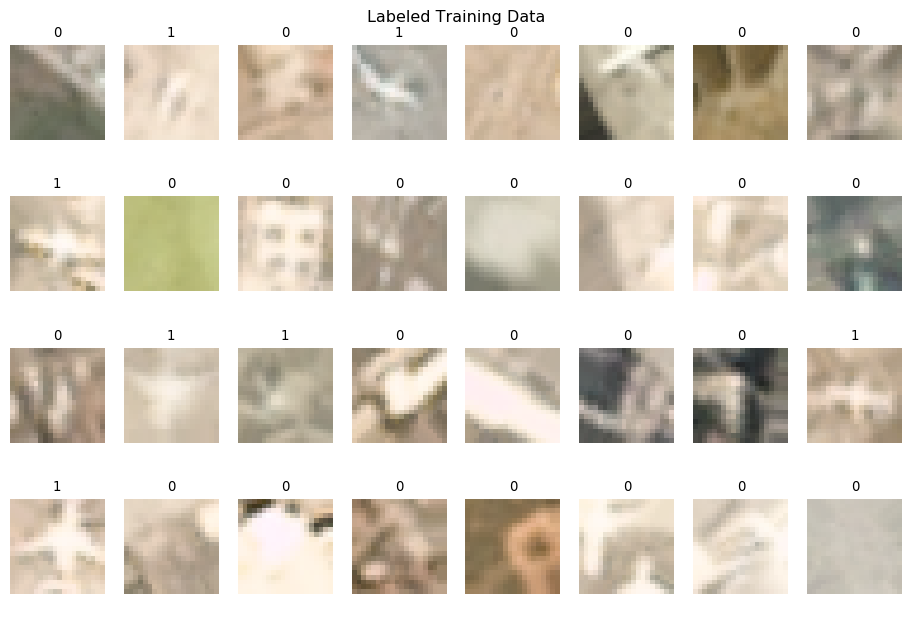

In [22]:
batches=0

for x_batch, y_batch in train_generator:
    print(batches, x_batch.shape)
    label_id = y_batch.argmax(axis=1)
    #label_id = y_batch
    
    #num_to_dump = 2
    #print(batches, x_batch[:num_to_dump,:,:,:])
    #print(batches, label_id[:num_to_dump])

    plots(x_batch, titles=label_id, rows=4, main_title="Labeled Training Data")
    batches += 1
    if batches >= 1:
        break

## train model

### early stop callback

In [23]:


PATIENCE = 30

early_stopping_calllback = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='auto')

### tensorboard callback

In [24]:


timestamp = time.strftime("%Y%m%d-%H%M%S")
log_dir = '/home/jupyter/tensorboard_logs/tutorial/planes_satellite/' + timestamp
print("tensorboard log path: {}".format(log_dir))

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

tensorboard log path: /home/jupyter/tensorboard_logs/tutorial/planes_satellite/20190601-153752


### model checkpoint callback

In [25]:


checkpoint_root = '/home/jupyter/model_checkpoints/planes_satellite'
checkpoint_filename = 'weights.{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint_filepath = checkpoint_root + '/' + checkpoint_filename

!mkdir -p $checkpoint_root

model_checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, period=1, verbose=1)

### << TRAINING MODEL >> 

In [ ]:

history = model.fit_generator(train_generator, 
                             epochs=EPOCHS,
                             verbose=1,
                             shuffle=True,
                             validation_data=valid_generator,
                             callbacks=[early_stopping_calllback, tensorboard_callback, model_checkpoint_callback]
                             )

Epoch 1/300
  1/760 [..............................] - ETA: 3:45:03 - loss: 0.7424 - binary_accuracy: 0.5156

W0601 15:38:22.291094 139931412813568 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.235888). Check your callbacks.


759/760 [============================>.] - ETA: 0s - loss: 0.2620 - binary_accuracy: 0.8895
Epoch 00001: val_loss improved from inf to 0.24607, saving model to /home/jupyter/model_checkpoints/planes_satellite/weights.01-0.2461.hdf5
760/760 [==============================] - 39s 51ms/step - loss: 0.2619 - binary_accuracy: 0.8896 - val_loss: 0.2461 - val_binary_accuracy: 0.9086
Epoch 2/300
759/760 [============================>.] - ETA: 0s - loss: 0.1824 - binary_accuracy: 0.9262
Epoch 00002: val_loss improved from 0.24607 to 0.16861, saving model to /home/jupyter/model_checkpoints/planes_satellite/weights.02-0.1686.hdf5
760/760 [==============================] - 21s 27ms/step - loss: 0.1823 - binary_accuracy: 0.9263 - val_loss: 0.1686 - val_binary_accuracy: 0.9508
Epoch 3/300
757/760 [============================>.] - ETA: 0s - loss: 0.1561 - binary_accuracy: 0.9398
Epoch 00003: val_loss improved from 0.16861 to 0.13856, saving model to /home/jupyter/model_checkpoints/planes_satellite/w

## evaluate

### current model and weights

In [ ]:
evaluation = model.evaluate_generator(test_generator)
print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))

### evaluate using best saved model and weights

In [ ]:
list_of_models = glob.glob(checkpoint_root + '/*.hdf5')
latest_model = max(list_of_models, key=path.getctime)
print(latest_model)

In [ ]:
from keras.models import load_model

best_model = load_model(latest_model)

In [ ]:
evaluation = best_model.evaluate_generator(test_generator)
print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))

### using best model, continue training using smaller learning rate

        
best_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

history = best_model.fit_generator(train_generator, 
                             epochs=EPOCHS,
                             verbose=1,
                             shuffle=True,
                             validation_data=valid_generator,
                             callbacks=[early_stopping_calllback, tensorboard_callback, model_checkpoint_callback]
                             )

## predict

### plot some predictions

In [ ]:
# predict a batch

(X_batch, y_batch) = next(test_generator)

y_batch_true = [str(val) for val in y_batch.argmax(axis=1)]

# make prediction
predictions = best_model.predict(X_batch)

y_batch_predict = [str(val) for val in predictions.argmax(axis=1)]

labels_tuple = zip(y_batch_predict, y_batch_true)
labels = ['/'.join(t) for t in labels_tuple]

plots(X_batch, titles=labels, rows=4, main_title="Predictions")




### plot some mis-predictions

In [ ]:
# define larger batch size for generator

large_test_generator = test_datagen.flow_from_directory(
    IMAGE_PATH + "/test",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=2*BATCH_SIZE,
    class_mode='categorical',
    )

In [ ]:
# predict a larger batch

(X_batch, y_batch) = next(large_test_generator)

y_batch_true = [str(val) for val in y_batch.argmax(axis=1)]

# make prediction
predictions = best_model.predict(X_batch)

y_batch_predict = [str(val) for val in predictions.argmax(axis=1)]

labels_tuple = zip(y_batch_predict, y_batch_true)
labels = ['/'.join(t) for t in labels_tuple]

errors = np.array(y_batch.argmax(axis=1)) - np.array(predictions.argmax(axis=1))

error_idx = np.nonzero(errors)[0]

if len(error_idx) > 0:
    X_batch_error = X_batch[error_idx]
    labels_error = [labels[idx] for idx in error_idx]
    
    rows = 1 + (len(error_idx) // 8)
    
    plots(X_batch_error, titles=labels_error, rows=rows, main_title="Wrong Predictions")